In [52]:
import pandas as pd 
import wandb
from tqdm import tqdm
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors

In [53]:
from read_wandb import wandb_results
api = wandb_results("nlp_d_and_n", wandb_username="nlp_d_and_n")

BASE_METRIC = "accuracy_per_mean_user_and_bot"


In [54]:
def result_metric(sweeps, group_name, drop_list=[0], drop_HPT=False, metric=BASE_METRIC, epoch="best"):
    df = api.get_sweeps_results(sweeps, metric=metric) 

    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    HPT_cols = [col for col in config_cols if df[col].nunique() > 1]
    print(HPT_cols)
    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]
        
    grouped = df.groupby([c for c in HPT_cols if c != "config_seed"])
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    mean_df = grouped[numeric_cols].mean()
    std_df = grouped[numeric_cols].std()
    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)
    
    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())


    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best": df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))

    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


# For HyperParameterTuning

For every configuration that you test in the sweep, you will receive in the table the average, standard deviation, all the values obtained for the different seed values, and also the confidence interval within which the result is located at a confidence level of 95%.

When epoch="best" is defined, you can check in which epoch the best result is obtained. If epoch=5 is defined, you will receive the result obtained for epoch number 5.

You can test multiple sweeps simultaneously by entering them into the list found in the first element of the function result_metric.

In [55]:
sweep_results = result_metric(["zgdtt1hz", "yx80t7nr", "r9wnx7er", "ff6f4rve", "552n1vik", "j8pdm5kq", "kwji76sh"], 
                              "natures", drop_HPT=False, epoch="best")

filename = 'sweep_results.csv'
sweep_results.to_pickle(filename)
print(f'DataFrame is saved to {filename} in the current project root.')
sweep_results

Total number of sweeps: 7
Download sweep_id='zgdtt1hz' data...
sweeps_csvs/zgdtt1hz_20.csv
Download sweep_id='yx80t7nr' data...
sweeps_csvs/yx80t7nr_3.csv
Download sweep_id='r9wnx7er' data...
sweeps_csvs/r9wnx7er_3.csv
Download sweep_id='ff6f4rve' data...
sweeps_csvs/ff6f4rve_1.csv
Download sweep_id='552n1vik' data...
sweeps_csvs/552n1vik_5.csv
Download sweep_id='j8pdm5kq' data...
sweeps_csvs/j8pdm5kq_6.csv
Download sweep_id='kwji76sh' data...
sweeps_csvs/kwji76sh_4.csv
['config_seed', 'config_basic_nature']
DataFrame is saved to sweep_results.csv in the current project root.


,mean,std,values,epoch,CI
natures,,,,,
12,0.836146,0.001935,"[0.8374156769701862, 0.8369360794551594, 0.838...",14,"(0.8347807601133058, 0.837390283618435)"
17,0.835860,0.003888,"[0.8338552463995709, 0.8323340860845863, 0.840...",16,"(0.8332712426349815, 0.8386173432322366)"
18,0.835465,0.001644,"[0.8349575683232312, 0.8365051794848003, 0.836...",6,"(0.8342484442669859, 0.8364056283884516)"
19,0.834345,0.002098,"[0.832264005027516, 0.8329809402511282, 0.8349...",10,"(0.8330060598498178, 0.835948328087064)"
20,0.836872,0.002920,"[0.8391052226873469, 0.8345268665177403, 0.841...",12,"(0.8349647799811468, 0.8389116360281799)"
21,0.834728,0.001998,"[0.834665297628474, 0.8354278996939842, 0.8321...",11,"(0.8334630600119086, 0.8361119764363822)"


# Result for a specific epoch

In [56]:
# sweep_results = result_metric(["kb9be58j"], "LLMs", drop_HPT=False, epoch=10)
# sweep_results

## Load a pickle of df

In [57]:
file_path = 'sweep_results.csv'
data = pd.read_pickle(file_path)
data


,mean,std,values,epoch,CI
natures,,,,,
12,0.836146,0.001935,"[0.8374156769701862, 0.8369360794551594, 0.838...",14,"(0.8347807601133058, 0.837390283618435)"
17,0.835860,0.003888,"[0.8338552463995709, 0.8323340860845863, 0.840...",16,"(0.8332712426349815, 0.8386173432322366)"
18,0.835465,0.001644,"[0.8349575683232312, 0.8365051794848003, 0.836...",6,"(0.8342484442669859, 0.8364056283884516)"
19,0.834345,0.002098,"[0.832264005027516, 0.8329809402511282, 0.8349...",10,"(0.8330060598498178, 0.835948328087064)"
20,0.836872,0.002920,"[0.8391052226873469, 0.8345268665177403, 0.841...",12,"(0.8349647799811468, 0.8389116360281799)"
21,0.834728,0.001998,"[0.834665297628474, 0.8354278996939842, 0.8321...",11,"(0.8334630600119086, 0.8361119764363822)"


In [64]:
import ast

def strip_newlines_and_eval(x):
    if isinstance(x, str):
        return ast.literal_eval(x.replace('\n', ''))
    return x

data['values'] = data['values'].apply(strip_newlines_and_eval)
data['CI'] = data['CI'].apply(strip_newlines_and_eval)

data['CI_lower'] = data['CI'].apply(lambda x: x[0])
data['CI_upper'] = data['CI'].apply(lambda x: x[1])

data.reset_index(inplace=True)

data.head()

,natures,mean,std,values,epoch,CI,CI_lower,CI_upper
0,12,0.836146,0.001935,"[0.8374156769701862, 0.8369360794551594, 0.838...",14,"(0.8347807601133058, 0.837390283618435)",0.834781,0.837390
1,17,0.835860,0.003888,"[0.8338552463995709, 0.8323340860845863, 0.840...",16,"(0.8332712426349815, 0.8386173432322366)",0.833271,0.838617
2,18,0.835465,0.001644,"[0.8349575683232312, 0.8365051794848003, 0.836...",6,"(0.8342484442669859, 0.8364056283884516)",0.834248,0.836406
3,19,0.834345,0.002098,"[0.832264005027516, 0.8329809402511282, 0.8349...",10,"(0.8330060598498178, 0.835948328087064)",0.833006,0.835948
4,20,0.836872,0.002920,"[0.8391052226873469, 0.8345268665177403, 0.841...",12,"(0.8349647799811468, 0.8389116360281799)",0.834965,0.838912


## All strategies plots

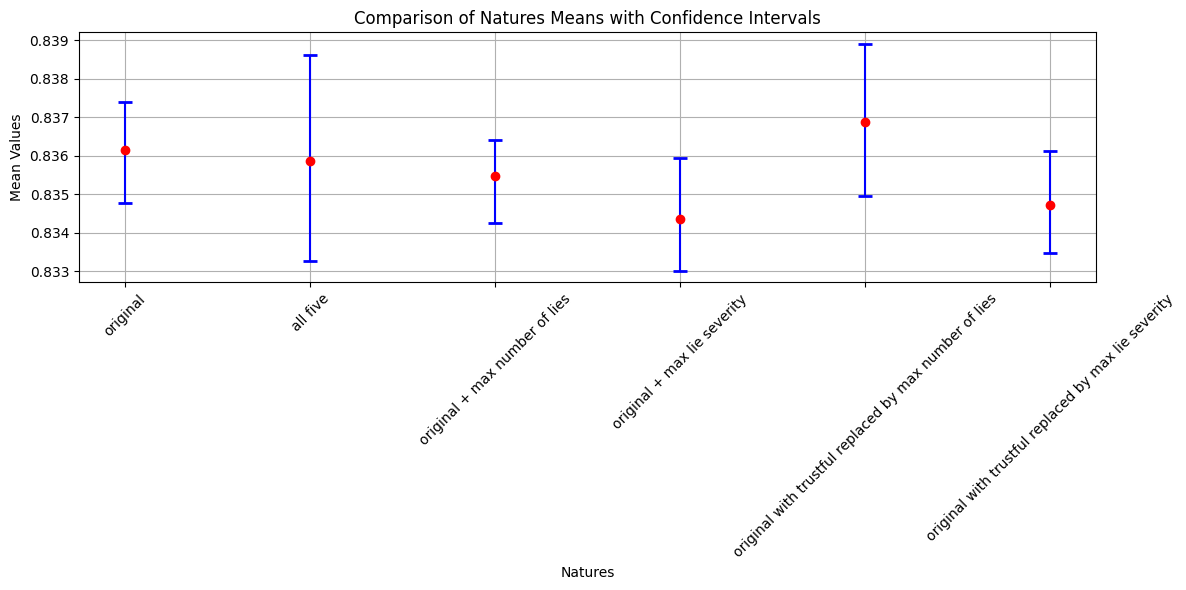

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data)

new_titles = {
    12: 'original',
    17: 'all five',
    18: 'original + max number of lies',
    19: 'original + max lie severity',
    20: 'original with trustful replaced by max number of lies',
    21: 'original with trustful replaced by max lie severity'
}

df['natures'] = df['natures'].replace(new_titles)

plt.figure(figsize=(12, 6))
plt.errorbar(df['natures'], df['mean'], yerr=[df['mean'] - df['CI_lower'], df['CI_upper'] - df['mean']],
             fmt='o', capsize=5, capthick=2, ecolor='blue', label='Mean with CI', color='red')
plt.title('Comparison of Natures Means with Confidence Intervals')
plt.xlabel('Natures')
plt.ylabel('Mean Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



## Strategies added plots 


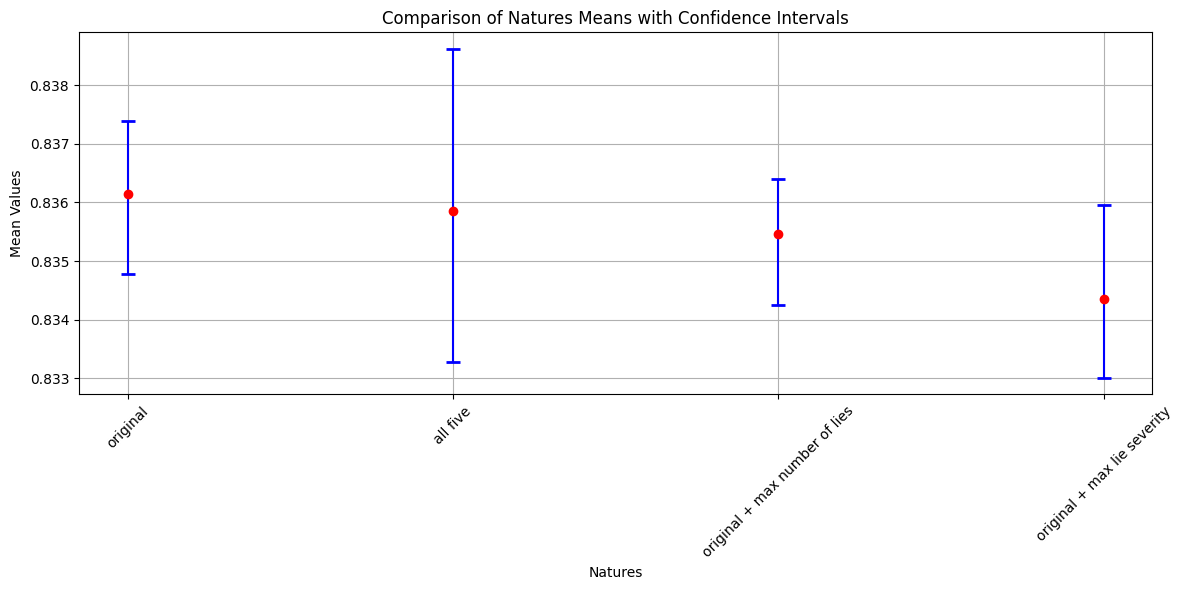

In [66]:
df = pd.DataFrame(data)

new_titles = {
    12: 'original',
    17: 'all five',
    18: 'original + max number of lies',
    19: 'original + max lie severity',
}

df['natures'] = df['natures'].replace(new_titles)

filtered_data = df[df['natures'].isin(new_titles.values())] 

plt.figure(figsize=(12, 6))
plt.errorbar(filtered_data['natures'], filtered_data['mean'], 
             yerr=[filtered_data['mean'] - filtered_data['CI_lower'], filtered_data['CI_upper'] - filtered_data['mean']],
             fmt='o', capsize=5, capthick=2, ecolor='blue', label='Mean with CI', color='red')
plt.title('Comparison of Natures Means with Confidence Intervals')
plt.xlabel('Natures')
plt.ylabel('Mean Values')
plt.xticks(rotation=45)  
plt.grid(True)
plt.tight_layout()  
plt.show()

## Strategies replaced plots

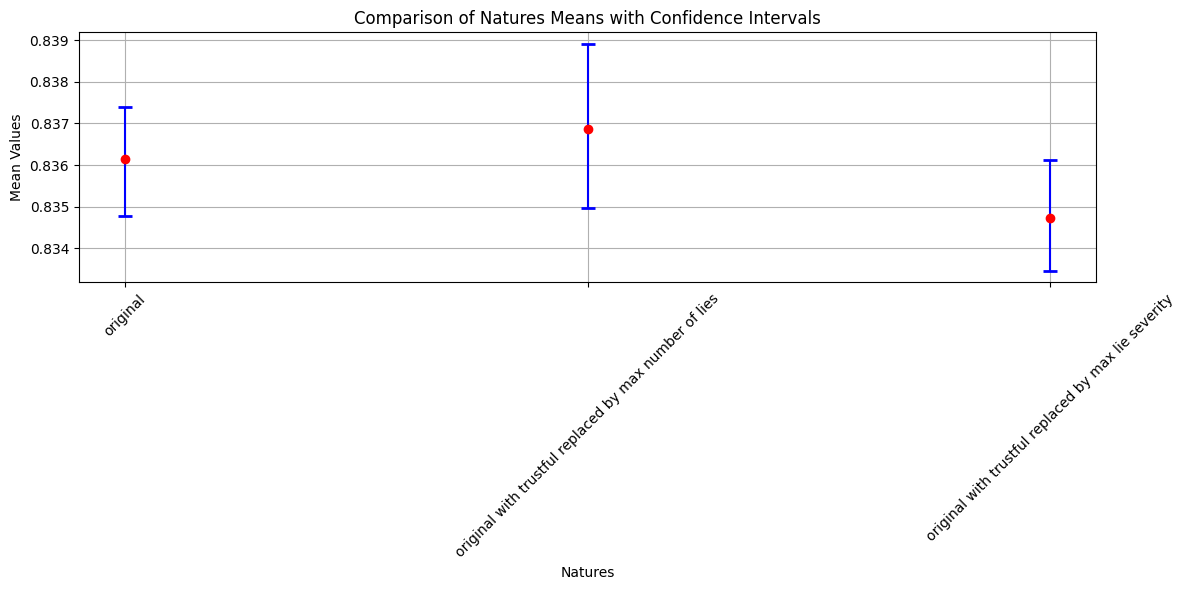

In [67]:
df = pd.DataFrame(data)

new_titles = {
    12: 'original',
    20: 'original with trustful replaced by max number of lies',
    21: 'original with trustful replaced by max lie severity'
}

df['natures'] = df['natures'].replace(new_titles)

filtered_data = df[df['natures'].isin(new_titles.values())] 

plt.figure(figsize=(12, 6))
plt.errorbar(filtered_data['natures'], filtered_data['mean'], 
             yerr=[filtered_data['mean'] - filtered_data['CI_lower'], filtered_data['CI_upper'] - filtered_data['mean']],
             fmt='o', capsize=5, capthick=2, ecolor='blue', label='Mean with CI', color='red')
plt.title('Comparison of Natures Means with Confidence Intervals')
plt.xlabel('Natures')
plt.ylabel('Mean Values')
plt.xticks(rotation=45)  
plt.grid(True)
plt.tight_layout()  
plt.show()

In [73]:
import numpy as np

data = data = pd.read_pickle(file_path)
data['values'] = data['values'].apply(strip_newlines_and_eval)
data.reset_index(inplace=True)

nature20 = data.loc[data['natures'] == 20, 'values'].values[0]
nature12 = data.loc[data['natures'] == 12, 'values'].values[0]

t_stat, p_value = stats.ttest_ind(nature20, nature12, equal_var=False, alternative='greater')

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("We reject the null hypothesis. The mean of nature20 is significantly higher than that of nature12.")
else:
    print("We fail to reject the null hypothesis. There is not enough evidence to conclude that the mean of nature20 is higher.")

T-statistic: 0.5481702882562932
P-value: 0.29756242604087946
We fail to reject the null hypothesis. There is not enough evidence to conclude that the mean of nature20 is higher.
